In [1]:
from datetime import datetime
from getpass import getpass

admin_rdm_url = 'https://admin.bh.rdm.yzwlab.com/' #'https://admin.staging.rdm.example.com/'
rdm_url = 'https://bh.rdm.yzwlab.com/'

idp_name_1 = None # 'GakuNin RDM IdP'
idp_username_1 = None
idp_password_1 = None
default_result_path = None
close_on_fail = False
transition_timeout = 30000

target_organization = 'Washington University in St. Louis [Test]'
quota_user_id = 'jbgaz'
yyyymmdd = datetime.now().strftime('%Y%m%d')
quota_project_name = f'管理者クォータテスト {yyyymmdd}'

In [2]:
if idp_username_1 is None:
    idp_username_1 = input(prompt=f'Username for {idp_name_1}')
if idp_password_1 is None:
    idp_password_1 = getpass(prompt=f'Password for {idp_username_1}@{idp_name_1}')
(len(idp_username_1), len(idp_password_1))

(7, 16)

# 定期監視-管理者-NIIストレージのクォータ

- サブシステム名: 管理者
- ページ/アドオン: 管理者
- 機能分類: ログイン
- シナリオ名: ログイン確認
- 用意するテストデータ: URL一覧、アカウント(管理者ユーザー1: GRDM)


## GakuNin RDM管理者ページのURLを開く

①ブラウザを開き、画面右上の設定メニューから「シークレットモードで開く」を選択する。  
②新規画面が開かれ、画面上において、「シークレットモードです」と表示されていることを確認する。
以下、シークレットモードにて確認を行う。

③ブラウザを開き、下記URLにアクセスする。  
https://rdm.example.com/  

In [3]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/tmp/tmp8z6o2tzb'

In [4]:
import importlib
import pandas as pd

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *
from scripts import grdm

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path)

('20251031-103704', '/tmp/tmp1wfzwx7c')

Start epoch: 1761907024.446089 seconds


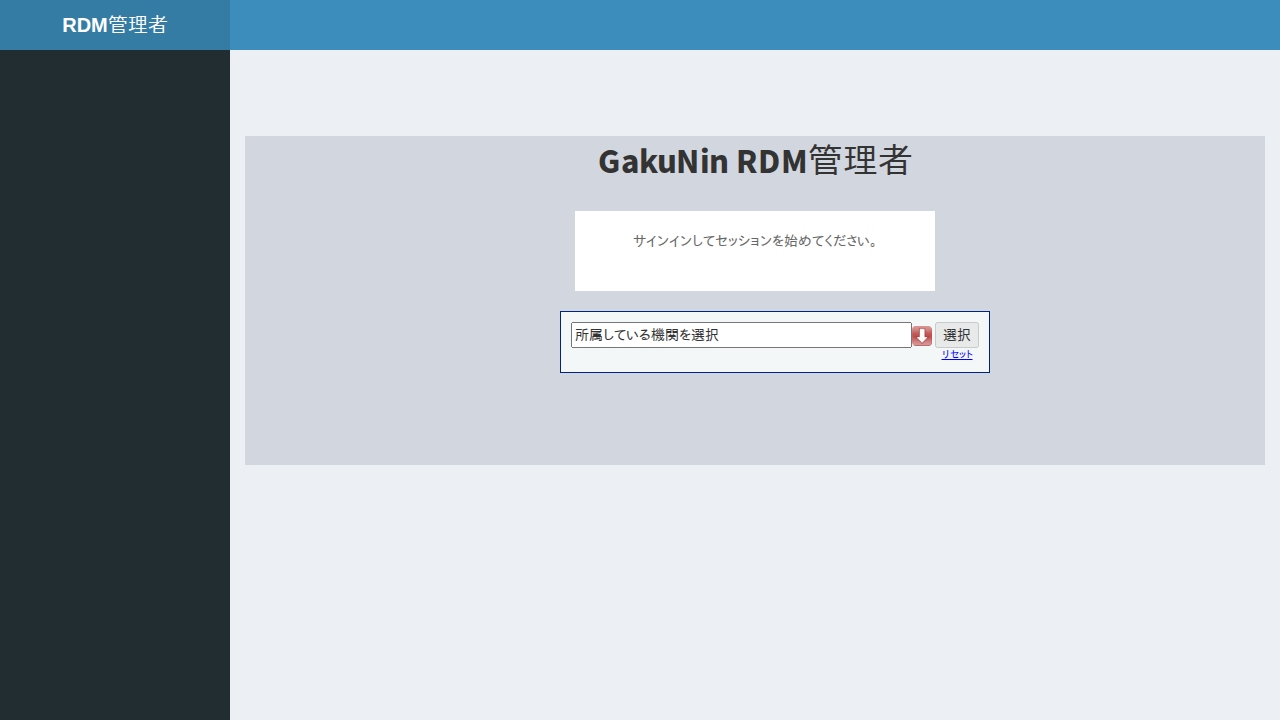

In [5]:
import time

async def _step(page):
    await page.goto(admin_rdm_url)

    await expect(page.locator('.login-logo')).to_be_visible(timeout=30000)

await run_pw(_step)

## ログイン情報を用いてGakuNin RDMにログインする

(IdPに関するログイン情報が与えられた場合、)
GakuNin Embeded DSのプルダウンを展開し、IdPリストから指定されたIdPを選択する。その後、アカウントのID/Passwordを入力して「Login」ボタンを押下する。

(IdPが指定されていない場合、)
CASのログイン操作を実施する。

Start epoch: 1761907026.9996812 seconds
ierae08
YibkH0U9-3^%Z@v8


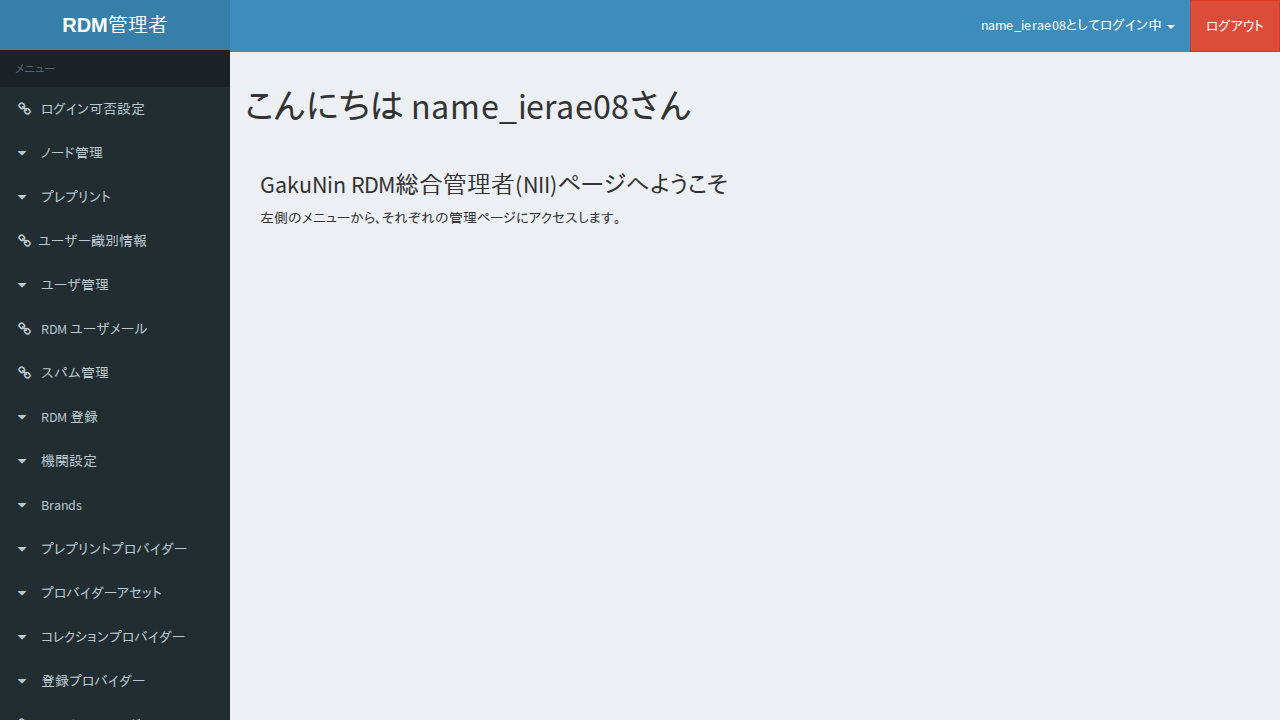

In [6]:
import scripts.grdm
importlib.reload(scripts.grdm)

async def _step(page):
    await scripts.grdm.login_as_admin(
        page, idp_name_1, idp_username_1, idp_password_1, transition_timeout=transition_timeout
    )

    await expect(page.locator('//*[contains(@class, "btn-danger") and contains(text(), "ログアウト")]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## 「NIIストレージのクォータ」を選択する

「NIIストレージ使用の機関のリスト」が表示される

Start epoch: 1761907034.1391003 seconds


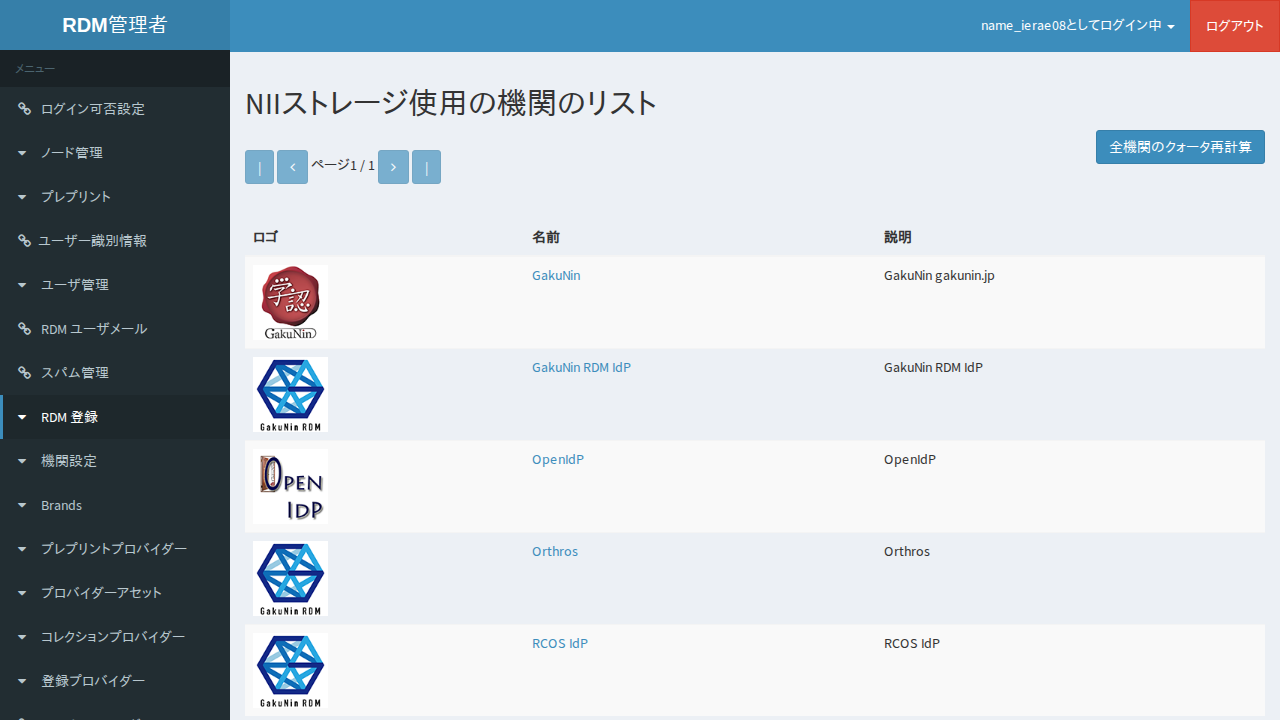

In [7]:
async def _step(page):
    await page.locator('//a[@href = "/institutions/institution_list/"]').click()

    await expect(page.locator('//h2[text() = "NIIストレージ使用の機関のリスト"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「機関のリスト」画面の名前から「GakuNin RDM IdP」を選択する

「GakuNin RDM IdP」の詳細が表示される

Start epoch: 1761907034.5732615 seconds


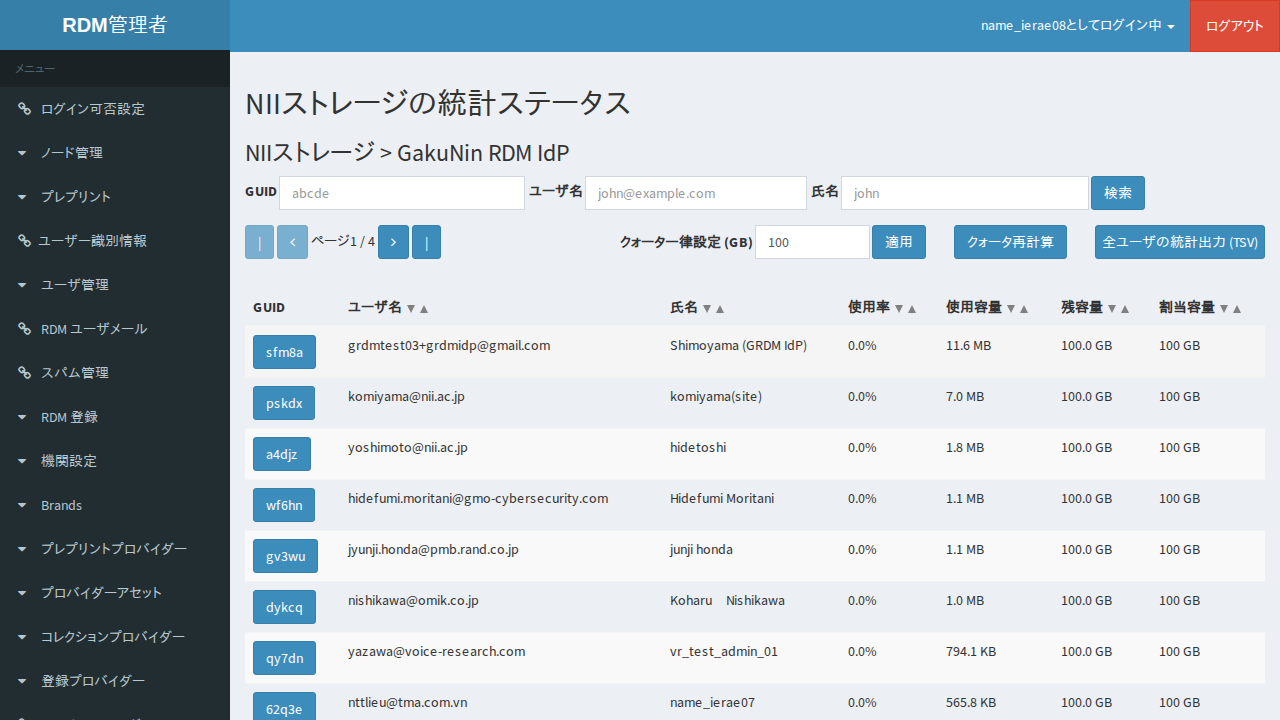

In [8]:
import traceback

async def _step(page):
    while True:
        link = page.locator(f'//a[text() = "{target_organization}"]')
        try:
            await expect(link).to_be_visible()
        except:
            traceback.print_exc()
            print('Search next page...')
            # 次のページかもしれない
            await page.locator('//a[i[contains(@class, "fa-angle-right")]]').click()
            await expect(page.locator('//h2[text() = "NIIストレージ使用の機関のリスト"]')).to_be_visible(timeout=transition_timeout)
            continue
        await link.click()
        break

    await expect(page.locator('//h2[contains(text(), "NIIストレージの統計ステータス")]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 検索フォームのGUID欄に (指定されたユーザーID) と入力し、「検索」ボタンを押下する

該当のユーザが表示される

Start epoch: 1761907035.3882248 seconds


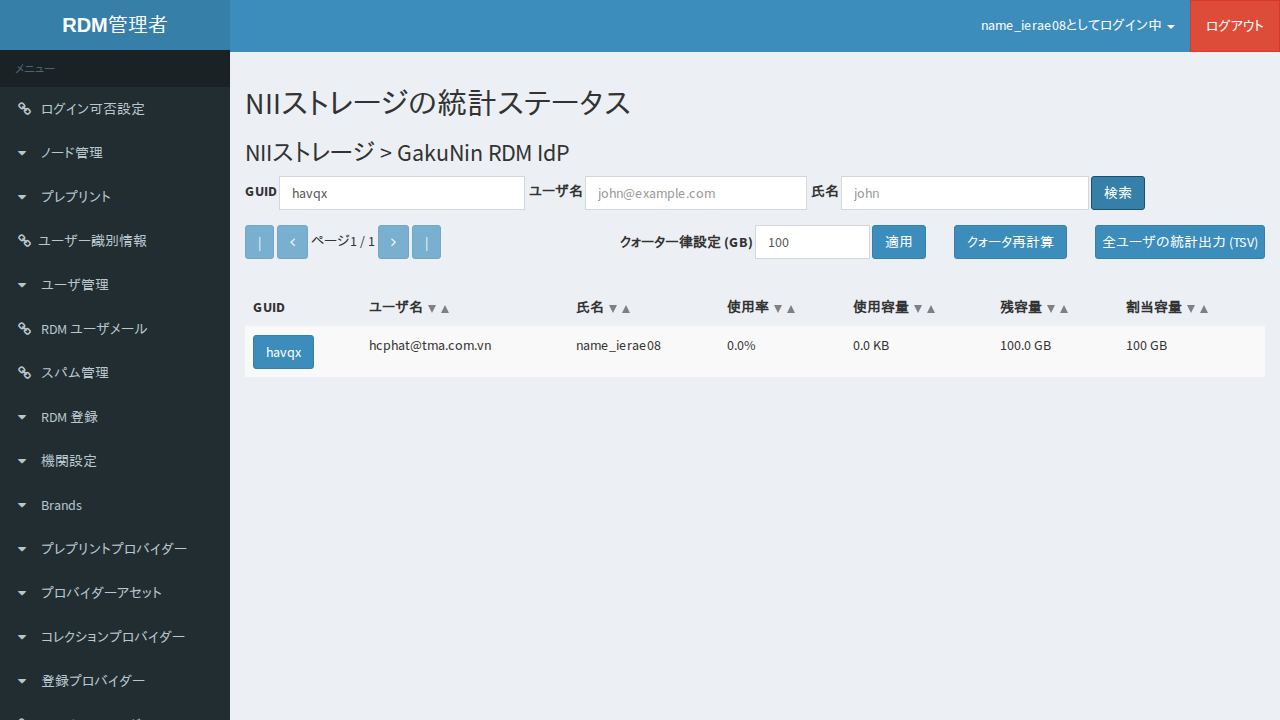

In [9]:
async def _step(page):
    await page.locator('#id_guid').fill(quota_user_id)
    await page.locator('//button[@type = "submit" and text() = "検索"]').click()

    await expect(page.locator(f'//a[contains(text(), "{quota_user_id}")]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## GUID「(指定されたユーザーID)」を押下する。

該当のユーザーのページに移動する

Start epoch: 1761907036.8253012 seconds


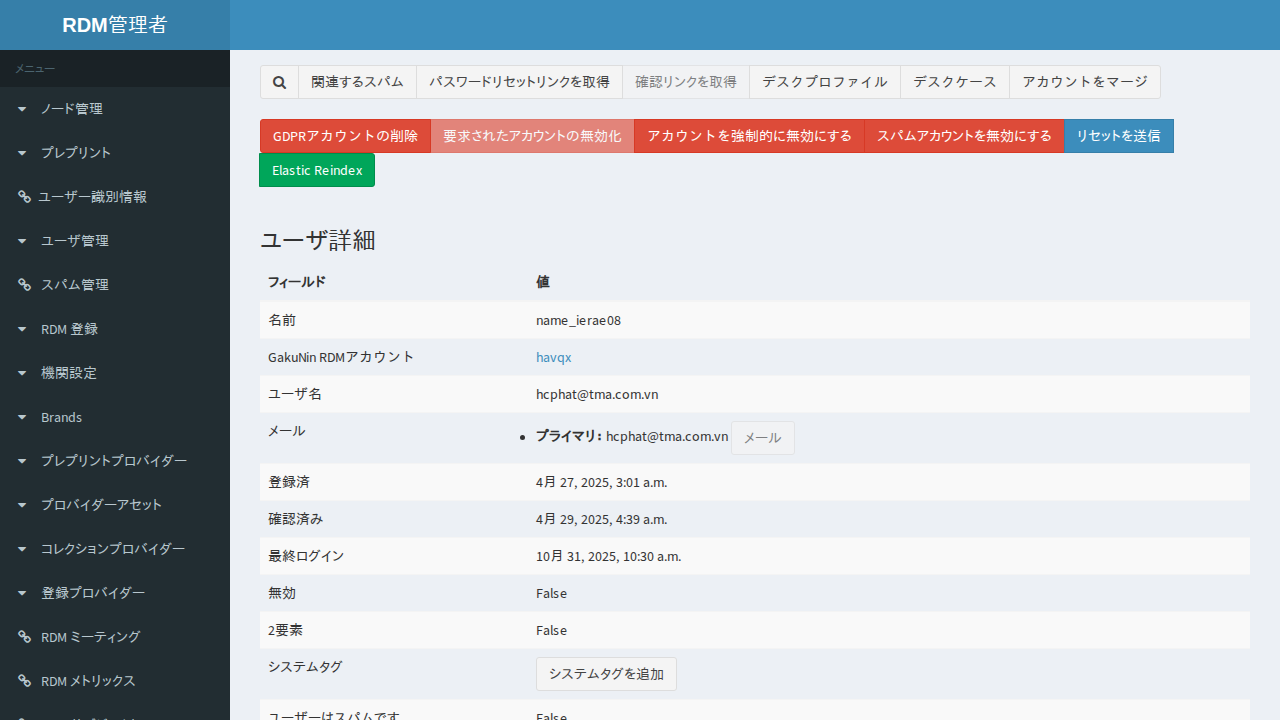

In [10]:
async def _step(page):
    await page.locator(f'//a[contains(text(), "{quota_user_id}")]').click()

    await expect(page.locator('//td[contains(text(), "NIIストレージの割当て")]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「NIIストレージの割当て」を"1"にし「適用」を押下する

該当のユーザの「NIIストレージの割当て」が1GBになる

Start epoch: 1761907037.4374917 seconds


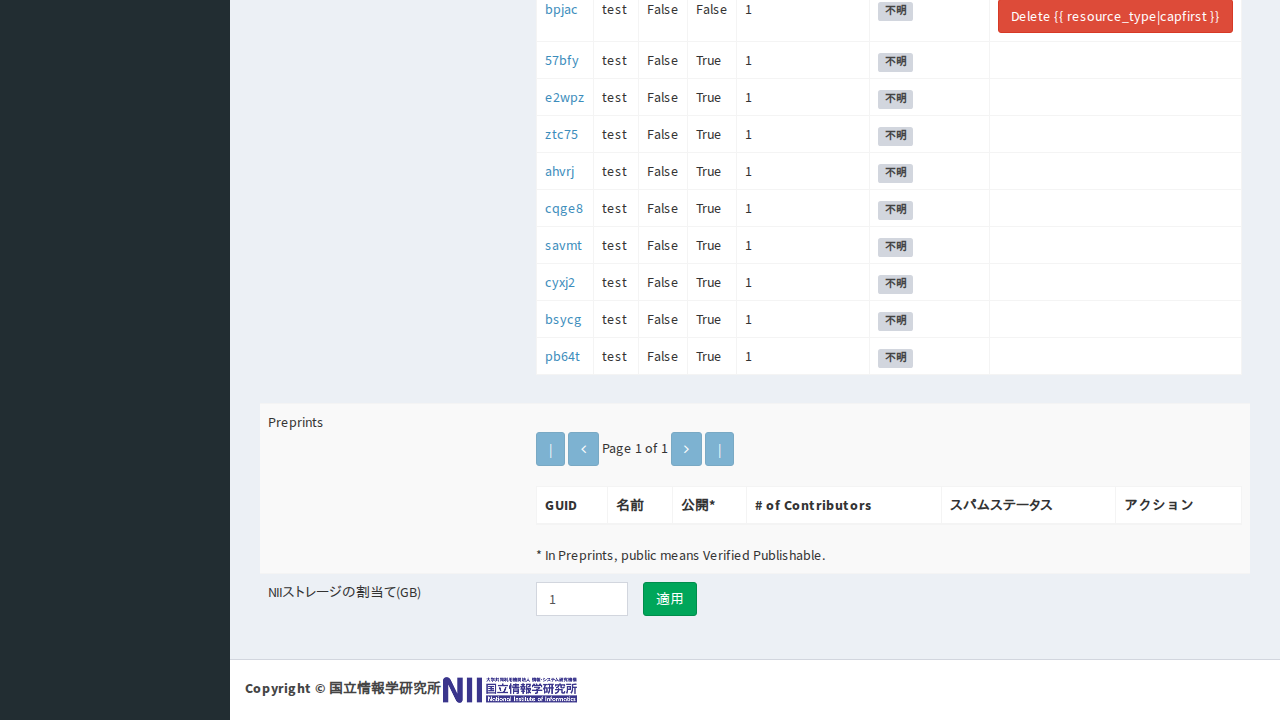

In [11]:
async def _step(page):
    await page.locator('#storageLimit').fill("1")
    await page.locator('#applyMaxQuota').click()

    await page.locator('#applyMaxQuota').scroll_into_view_if_needed()
    await expect(page.locator('#storageLimit')).to_have_value('1', timeout=transition_timeout)

await run_pw(_step)

## GakuNin RDMのページに移動する

GakuNin RDMのTOPページが開かれる

In [12]:
# rdm_url = 'https://bh.rdm.yzwlab.com/'

# from datetime import datetime

# yyyymmdd = datetime.now().strftime('%Y%m%d')
# quota_project_name = f'管理者クォータテスト {yyyymmdd}'

Start epoch: 1761907038.2252085 seconds


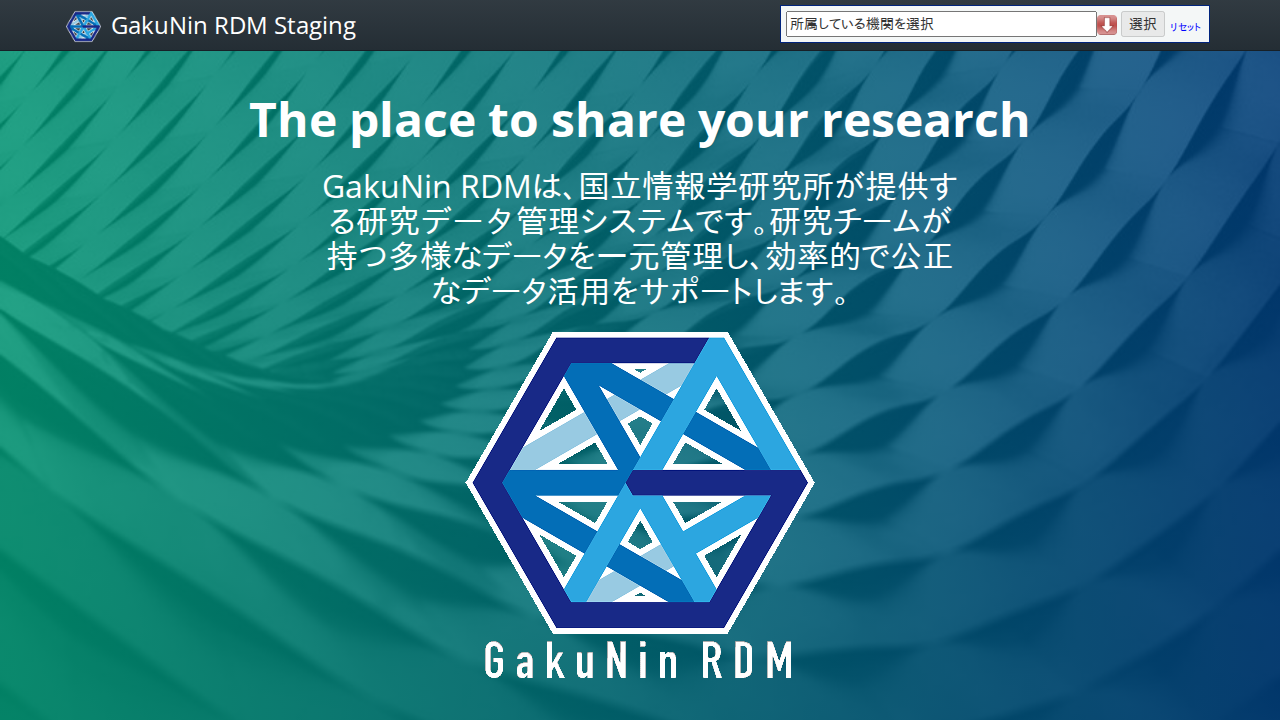

In [13]:
import time

async def _step(page):
    await page.goto(rdm_url)

    # 同意する ボタンが現れるまで待つ
    await expect(page.locator('//button[text() = "同意する"]')).to_be_visible(timeout=transition_timeout)

    # 同意する をクリック
    await page.locator('//button[text() = "同意する"]').click()

    # 同意する が表示されなくなったことを確認
    await expect(page.locator('//button[text() = "同意する"]')).to_have_count(0, timeout=500)

await run_pw(_step)

## ログイン情報を用いてGakuNin RDMにログインする

(IdPに関するログイン情報が与えられた場合、)
GakuNin Embeded DSのプルダウンを展開し、IdPリストから指定されたIdPを選択する。その後、アカウントのID/Passwordを入力して「Login」ボタンを押下する。

(IdPが指定されていない場合、)
CASのログイン操作を実施する。

Start epoch: 1761907040.2339442 seconds
ierae08
YibkH0U9-3^%Z@v8


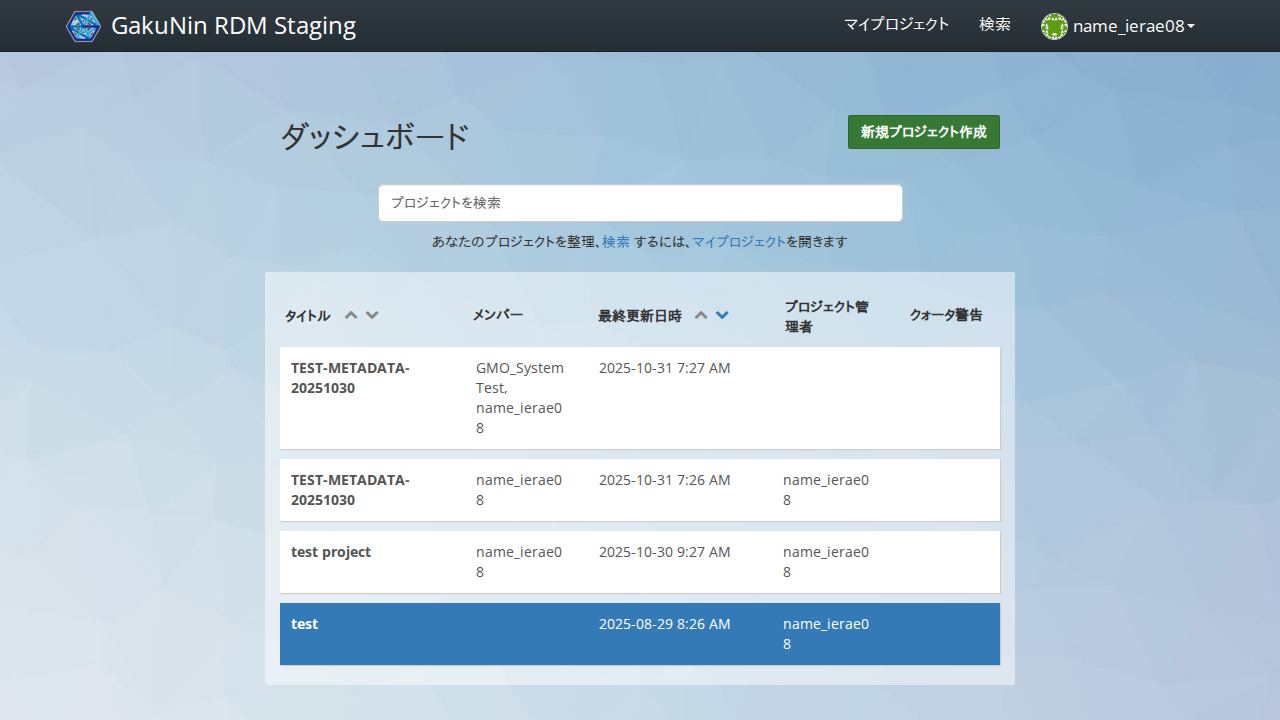

In [14]:
import scripts.grdm
importlib.reload(scripts.grdm)

async def _step(page):
    await scripts.grdm.login(
        page, idp_name_1, idp_username_1, idp_password_1, transition_timeout=transition_timeout
    )

    await scripts.grdm.expect_dashboard(page, transition_timeout=transition_timeout)

await run_pw(_step)

## プロジェクト一覧に指定されたタイトルのプロジェクトがあればそのプロジェクトを開き、ない場合は指定された名前のプロジェクトを作成する


Start epoch: 1761907048.5570147 seconds


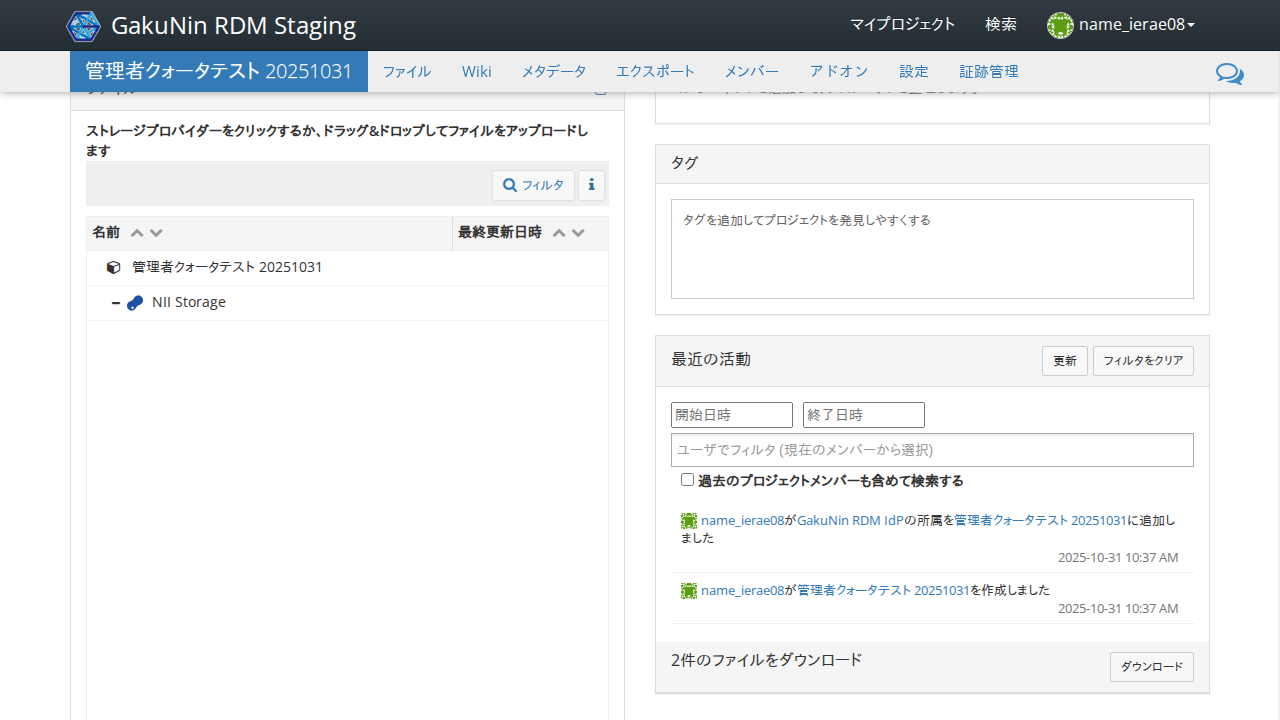

In [15]:
# import scripts.grdm
# importlib.reload(scripts.grdm)

target_storage_name = 'NII Storage'

async def _step(page):
    await expect(page.locator('//*[@data-test-create-project-modal-button]')).to_have_count(1)

    await scripts.grdm.ensure_project_exists(page, quota_project_name, transition_timeout=transition_timeout)
    await page.locator(f'//*[@data-test-dashboard-item-title and text()="{quota_project_name}"]').click()        

    await expect(page.locator('//a[text() = "アドオン"]')).to_be_visible(timeout=transition_timeout)
    await expect(grdm.get_select_expanded_storage_title_locator(page, target_storage_name)).to_be_visible(timeout=transition_timeout)
    time.sleep(1)

    await page.locator('//h3[text()="最近の活動"]').click()

await run_pw(_step)

## ファイル一覧の対象ストレージにファイル(1GB)をアップロードする

ファイルを追加できないことを確認する

1024+0 records in
1024+0 records out
1073741824 bytes (1.1 GB, 1.0 GiB) copied, 0.388999 s, 2.8 GB/s
-rw-r--r-- 1 jovyan users 1073741824 Oct 31 10:37 /tmp/tmp8z6o2tzb/20251031_アップロードテスト_1GB.dat
Start epoch: 1761907061.6833348 seconds


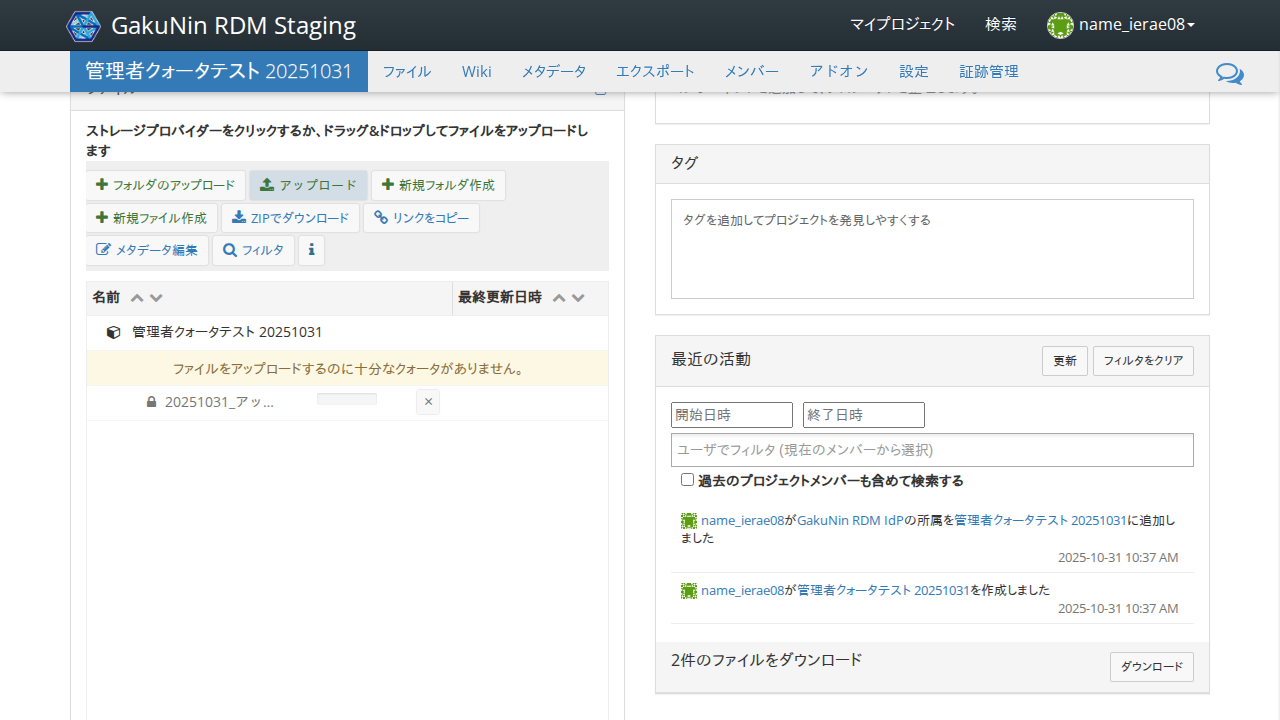

In [16]:
import asyncio
import traceback
from datetime import datetime

# ファイルの作成
filename = f'{yyyymmdd}_アップロードテスト_1GB.dat'
filepath = os.path.join(work_dir, filename)

!dd if=/dev/zero of={filepath} bs=1M count=1024
!ls -la {filepath}

async def _step(page):
    await grdm.get_select_storage_title_locator(page, target_storage_name).click()
    await page.locator('//h3[text()="最近の活動"]').click()
    await grdm.upload_file(page, filepath)
    await expect(page.locator('//*[contains(text(), "ファイルをアップロードするのに十分な")]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 機関管理者ページに移動し、「NIIストレージの割当て」を"100"にし「適用」を押下する

該当のユーザの「機関ストレージの割り当て」が100になる

Start epoch: 1761907062.2369764 seconds


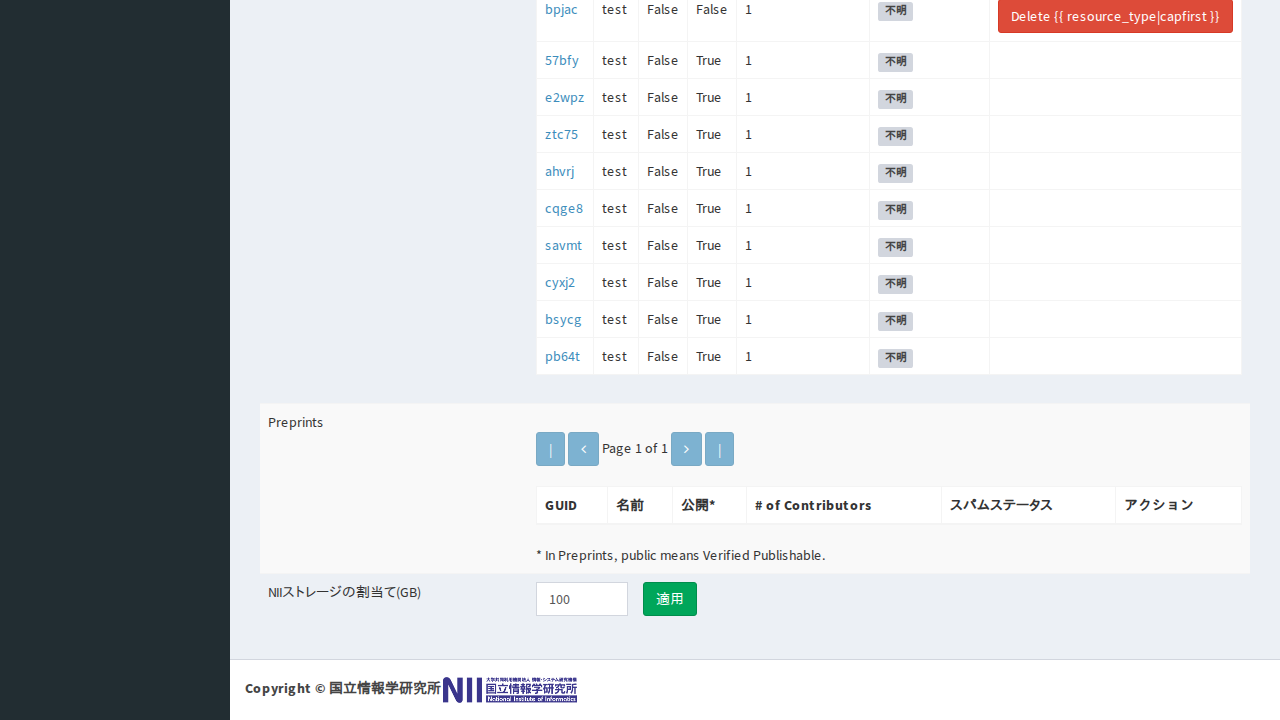

In [17]:
project_url = None

async def _step(page):
    global project_url
    project_url = page.url
    
    await page.goto(admin_rdm_url)
    await page.locator('//a[@href = "/institutions/institution_list/"]').click()

    await expect(page.locator('//h2[text() = "NIIストレージ使用の機関のリスト"]')).to_be_visible(timeout=transition_timeout)
    while True:
        link = page.locator(f'//a[text() = "{target_organization}"]')
        try:
            await expect(link).to_be_visible()
        except:
            traceback.print_exc()
            print('Search next page...')
            # 次のページかもしれない
            await page.locator('//a[i[contains(@class, "fa-angle-right")]]').click()
            await expect(page.locator('//h2[text() = "NIIストレージ使用の機関のリスト"]')).to_be_visible(timeout=transition_timeout)
            continue
        await link.click()
        break

    await expect(page.locator('//h2[contains(text(), "NIIストレージの統計ステータス")]')).to_be_visible(timeout=transition_timeout)
    await page.locator('#id_guid').fill(quota_user_id)
    await page.locator('//button[@type = "submit" and text() = "検索"]').click()

    await expect(page.locator(f'//a[contains(text(), "{quota_user_id}")]')).to_be_visible(timeout=transition_timeout)
    await page.locator(f'//a[contains(text(), "{quota_user_id}")]').click()

    await expect(page.locator('//td[contains(text(), "NIIストレージの割当て")]')).to_be_visible(timeout=transition_timeout)
    await page.locator('#storageLimit').fill("100")
    await page.locator('#applyMaxQuota').click()

    await page.locator('#applyMaxQuota').scroll_into_view_if_needed()
    await expect(page.locator('#storageLimit')).to_have_value('100', timeout=transition_timeout)

await run_pw(_step)

## GakuNin RDMのページに移動する

Start epoch: 1761907064.6386836 seconds


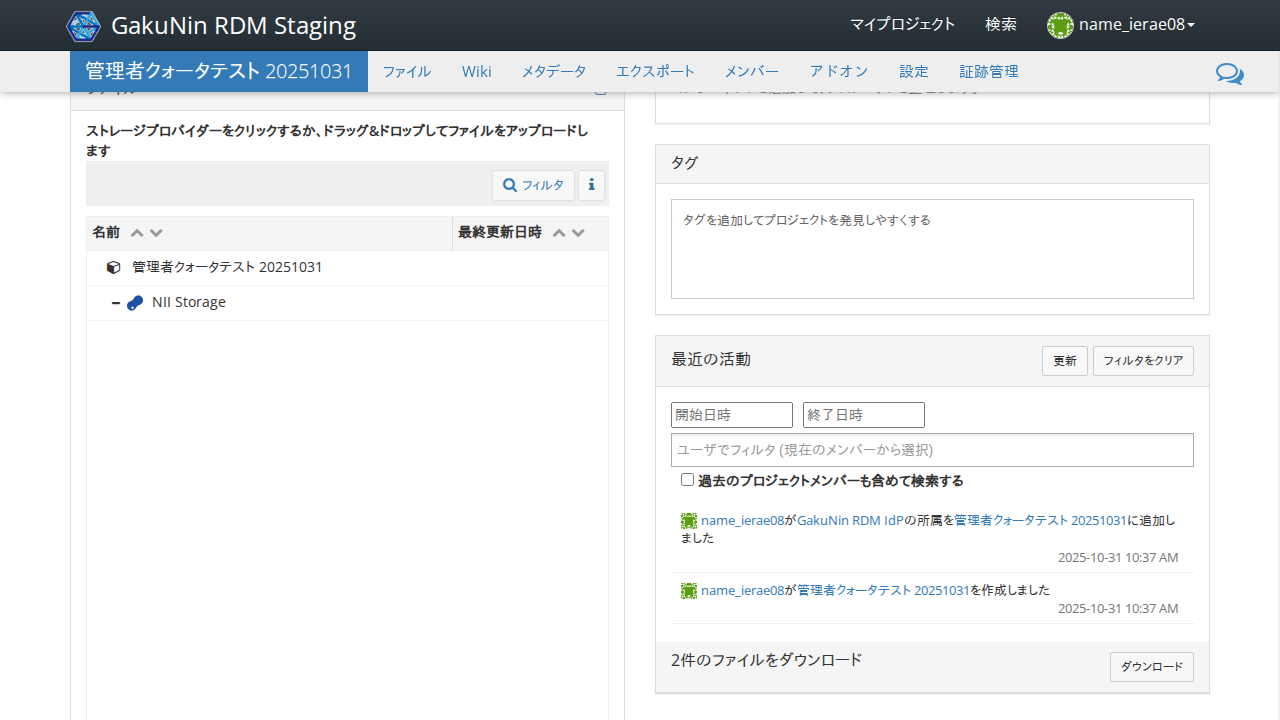

In [18]:
async def _step(page):
    await page.goto(project_url)
    await expect(page.locator('//a[text() = "アドオン"]')).to_be_visible(timeout=transition_timeout)
    await expect(grdm.get_select_expanded_storage_title_locator(page, target_storage_name)).to_be_visible(timeout=transition_timeout)
    time.sleep(1)

    await page.locator('//h3[text()="最近の活動"]').click()

await run_pw(_step)

## ファイル一覧の対象ストレージにファイル(1GB)をアップロードする

ファイルを追加できることを確認する。

Start epoch: 1761907068.8291965 seconds


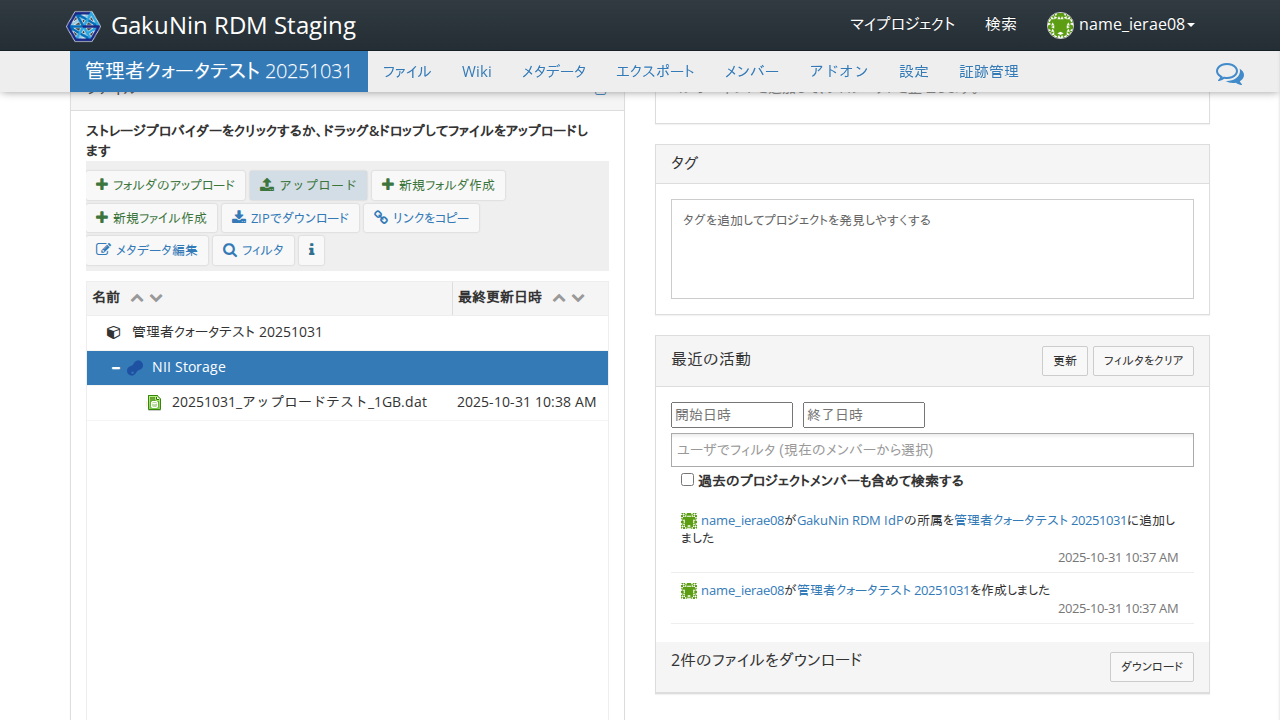

In [19]:
async def _step(page):
    await grdm.get_select_storage_title_locator(page, target_storage_name).click()
    await grdm.upload_file(page, filepath)
    await expect(page.locator(f'//*[text() = "{filename}"]/../following-sibling::*//*[@role = "progressbar"]')).to_have_count(1, timeout=transition_timeout)

    await expect(page.locator(f'//*[text() = "{filename}"]/../following-sibling::*//*[@role = "progressbar"]')).to_have_count(0, timeout=transition_timeout * 25)
    await expect(grdm.get_select_file_title_locator(page, filename)).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## プロジェクトを削除する

Start epoch: 1761907095.4344685 seconds
Pearce


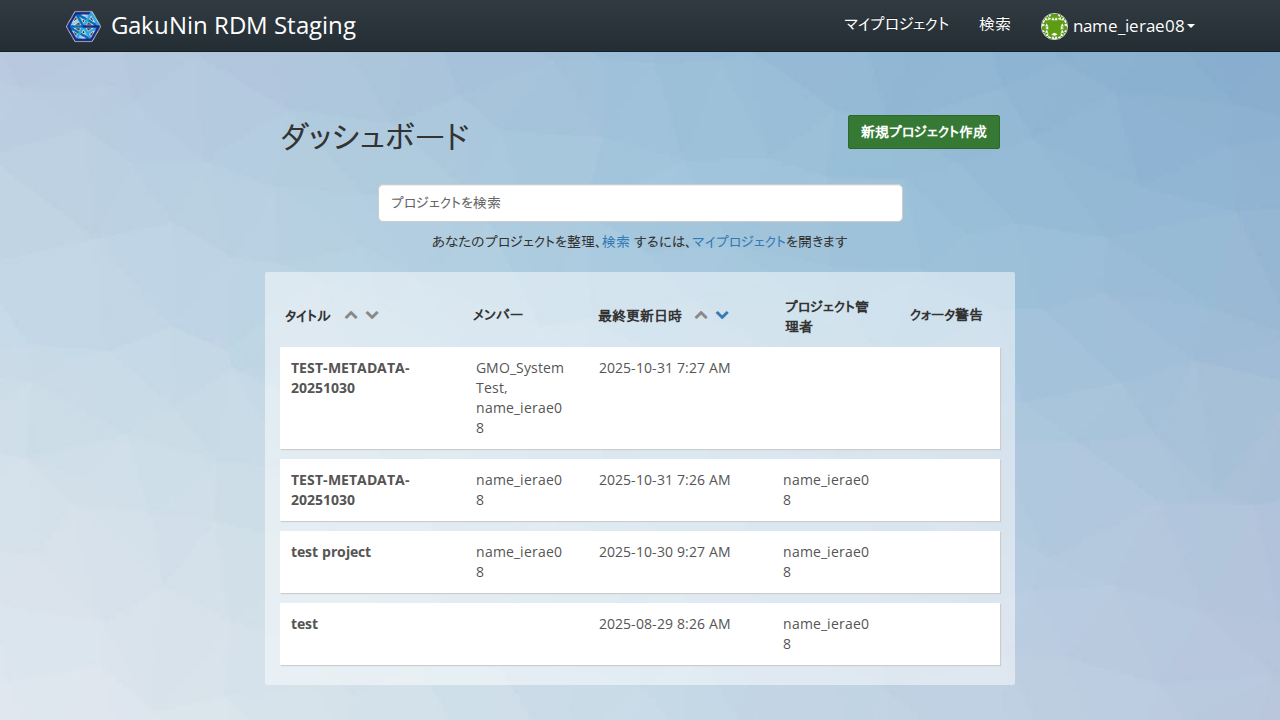

In [20]:
async def _step(page):
    await scripts.grdm.delete_project(page)

    await scripts.grdm.expect_dashboard(page, transition_timeout=transition_timeout)

await run_pw(_step)

終了処理を実施。

In [21]:
await finish_pw_context()

Video: result/result-20251031-094222/取りまとめ-管理者機能/notebooks/テスト手順-管理者機能-NIIストレージのクォータ/video-1.webm
HAR: result/result-20251031-094222/取りまとめ-管理者機能/notebooks/テスト手順-管理者機能-NIIストレージのクォータ/har.zip


スクリーンキャプチャ動画の取得に失敗しました。
Traceback (most recent call last):
  File "/home/jovyan/scripts/playwright.py", line 168, in _finish_pw_context
    shutil.copyfile(video_path, dest_video_path)
  File "/opt/conda/lib/python3.12/shutil.py", line 260, in copyfile
    with open(src, 'rb') as fsrc:
         ^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp1wfzwx7c/videos/9222ed2bb3fd172e1b06e79c29057704.webm'


In [22]:
!rm -fr {work_dir}